In [2]:
# %load_ext jupyter_black
# %load_ext autoreload
# %autoreload 2

In [3]:
import sys

sys.path.append("..")

## Modeling

In [4]:
import pandas as pd
from utils.utils import set_seed

set_seed()

### Load data

In [5]:
ds_train = pd.read_csv("../data/avila/avila-tr.txt", header=None)
ds_test = pd.read_csv("../data/avila/avila-ts.txt", header=None)

### Models

In [6]:
# -- Required models --

# KNN
from sklearn.neighbors import KNeighborsClassifier

# LVQ
from sklvq import GLVQ

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# SVM
from sklearn.svm import SVC

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# MLP
from sklearn.neural_network import MLPClassifier

# Ensemble
from sklearn.ensemble import VotingClassifier, BaggingClassifier

# -- Optional models --

# XGBoost
from xgboost import XGBClassifier

In [7]:
# -- Auxiliar functions --

from time import time


# Compute Training Time
class Timer:
    def __init__(self):
        self.start = time()

    def __call__(self):
        return time() - self.start

### Training

In [8]:
# Metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

# import label encoder
from sklearn.preprocessing import LabelEncoder

def get_model_name(model):
    if model.__class__.__name__ == "VotingClassifier":
        return model.__class__.__name__ + '_' + '_'.join([estimator[0] for estimator in model.estimators])
    return model.__class__.__name__

# Compute metrics
def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="macro", zero_division=1),
        "recall": recall_score(y_true, y_pred, average="macro", zero_division=1),
        "f1": f1_score(y_true, y_pred, average="macro", zero_division=1),
    }


# Split data
X_train = ds_train.iloc[:, :-1]
y_train = ds_train.iloc[:, -1]
X_test = ds_test.iloc[:, :-1]
y_test = ds_test.iloc[:, -1]

label_encoder = LabelEncoder().fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

#### Training - Baseline

In [9]:
%%time

# Best models of a pre-run are chosen to ensemble
models = [
    KNeighborsClassifier(),
    GLVQ(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    VotingClassifier(estimators=[('dt', DecisionTreeClassifier()), ('knn', KNeighborsClassifier()), ('rf', RandomForestClassifier())], voting = 'hard'),
    VotingClassifier(estimators=[('mlp1', MLPClassifier()), ('mlp2', MLPClassifier()), ('mlp3', MLPClassifier()) ], voting = 'hard')
]

models_results = {get_model_name(model): {} for model in models}

for model in models:
    print("Training model: ", get_model_name(model))

    timer = Timer()
    model.fit(X_train, y_train)
    metrics = compute_metrics(y_test, model.predict(X_test))
    metrics["fit_time"] = timer()
    
    # add new name to dataframe
    models_results[get_model_name(model)] = metrics

Training model:  KNeighborsClassifier
Training model:  GLVQ
Training model:  SVC
Training model:  DecisionTreeClassifier
Training model:  RandomForestClassifier
Training model:  XGBClassifier
Training model:  MLPClassifier


c:\Users\Matheus\Documents\Git\machine_learning_ufpe_2023_2\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training model:  VotingClassifier_dt_knn_rf
Training model:  VotingClassifier_mlp1_mlp2_mlp3


c:\Users\Matheus\Documents\Git\machine_learning_ufpe_2023_2\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Matheus\Documents\Git\machine_learning_ufpe_2023_2\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


CPU times: total: 50.1 s
Wall time: 50.3 s


c:\Users\Matheus\Documents\Git\machine_learning_ufpe_2023_2\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [10]:
models_results = pd.DataFrame(models_results).T.dropna()
models_results

,accuracy,precision,recall,f1,fit_time
KNeighborsClassifier,0.749545,0.809206,0.665667,0.718285,0.878034
GLVQ,0.543451,0.404941,0.434118,0.376341,14.214493
SVC,0.674523,0.820989,0.532343,0.569366,7.415507
DecisionTreeClassifier,0.969340,0.958798,0.964713,0.961587,0.062004
RandomForestClassifier,0.983999,0.990656,0.981099,0.985795,1.905971
XGBClassifier,0.881958,0.943424,0.904685,0.921704,4.968038
MLPClassifier,0.790649,0.826146,0.768335,0.784845,4.356999
VotingClassifier_dt_knn_rf,0.978250,0.984551,0.970615,0.977442,2.816997
VotingClassifier_mlp1_mlp2_mlp3,0.800038,0.842897,0.794586,0.813672,13.672216


### Stratified KFold

In [11]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

def stratified_cross_val(model_list, data, n_folds=30, n_splits=10):
    model_results = {get_model_name(model): [] for model in model_list}

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

    X = data.iloc[:, :-1]
    y = LabelEncoder().fit_transform(data.iloc[:, -1])

    for model in model_list:
        pipeline = Pipeline(
            [
                # ("scaler", StandardScaler()), # uncomment to scale data
                ("model", model)
            ]
        )

        for _ in range(n_folds):
            iter_scores = cross_validate(
                pipeline,
                X,
                y,
                cv=cv,
                scoring={
                    "f1_score": "f1_macro",
                    "precision_score": "precision_macro",
                    "accuracy_score": "accuracy",
                    "recall_score": "recall_macro",
                },
                n_jobs=-1,
            )
            model_results[get_model_name(model)].append(iter_scores)

    return model_results



def model_results_to_df(model_results):
    res_final = pd.DataFrame(
        columns=[
            "fit_time",
            "score_time",
            "test_f1_score",
            "test_precision_score",
            "test_accuracy_score",
            "test_recall_score",
            "split",
            "model",
        ]
    )

    for model in model_results.keys():
        for i in range(len(model_results[model])):
            _res = pd.DataFrame(
                model_results[model][i].values(),
                index=model_results[model][i].keys(),
            ).T
            _res["split"] = i
            _res["model"] = model
            res_final = pd.concat([res_final, _res])

    return res_final

In [12]:
models = [
    KNeighborsClassifier(),
    GLVQ(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    VotingClassifier(estimators=[('dt', DecisionTreeClassifier()), ('knn', KNeighborsClassifier()), ('rf', RandomForestClassifier())], voting = 'hard'),
    VotingClassifier(estimators=[('mlp1', MLPClassifier()), ('mlp2', MLPClassifier()), ('mlp3', MLPClassifier()) ], voting = 'hard')
]

stratified_crossval_results = model_results_to_df(
    stratified_cross_val(models, ds_train, n_folds=10, n_splits=5)
)

stratified_crossval_results.head().style

,fit_time,score_time,test_f1_score,test_precision_score,test_accuracy_score,test_recall_score,split,model
0,0.017999,0.204001,0.662725,0.768616,0.725312,0.609600,0,KNeighborsClassifier
1,0.018001,0.183029,0.664454,0.717812,0.719080,0.628879,0,KNeighborsClassifier
2,0.018001,0.228030,0.671882,0.763786,0.723394,0.623001,0,KNeighborsClassifier
3,0.016000,0.190033,0.675110,0.751459,0.731544,0.650122,0,KNeighborsClassifier
4,0.017999,0.205033,0.689486,0.773744,0.718121,0.639944,0,KNeighborsClassifier


### Metrics

In [13]:
stratified_crossval_results.groupby("model").mean(numeric_only=True).style

,fit_time,score_time,test_f1_score,test_precision_score,test_accuracy_score,test_recall_score
model,,,,,,
DecisionTreeClassifier,0.052646,0.007042,0.920437,0.921671,0.960978,0.922950
GLVQ,13.623662,0.006338,0.368895,0.406981,0.544219,0.432706
KNeighborsClassifier,0.018000,0.191244,0.672202,0.757279,0.722013,0.626278
MLPClassifier,4.483164,0.007424,0.763830,0.811531,0.772109,0.740749
RandomForestClassifier,1.738540,0.045447,0.969969,0.980804,0.979636,0.960570
SVC,1.618355,1.077606,0.558071,0.747697,0.670690,0.520497
VotingClassifier_dt_knn_rf,1.788802,0.248622,0.964048,0.977481,0.970959,0.953076
VotingClassifier_mlp1_mlp2_mlp3,13.342913,0.021733,0.773317,0.824695,0.780038,0.746405
XGBClassifier,4.645920,0.076783,0.913530,0.926304,0.871841,0.907696


In [14]:
stratified_crossval_results.groupby("model").std(numeric_only=True).style

,fit_time,score_time,test_f1_score,test_precision_score,test_accuracy_score,test_recall_score
model,,,,,,
DecisionTreeClassifier,0.004423,0.001194,0.040221,0.039046,0.010704,0.042206
GLVQ,0.295441,0.001242,0.016652,0.023565,0.009373,0.015559
KNeighborsClassifier,0.002031,0.012692,0.022210,0.023330,0.010382,0.022672
MLPClassifier,0.164003,0.001429,0.018031,0.020822,0.008905,0.019499
RandomForestClassifier,0.112805,0.006078,0.021325,0.020938,0.004300,0.022478
SVC,0.109788,0.081482,0.031678,0.059920,0.017694,0.027119
VotingClassifier_dt_knn_rf,0.052124,0.014962,0.010923,0.011054,0.005570,0.011811
VotingClassifier_mlp1_mlp2_mlp3,0.462516,0.003397,0.016458,0.017227,0.008614,0.017594
XGBClassifier,0.132852,0.006740,0.014363,0.018882,0.007937,0.011231


### Tuning

In [44]:
import optuna
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
import os
# Avoid use n_jobs=-1 in each call of sklearn model
os.environ["JOBLIB_MULTIPROCESSING"] = "true"

def objective(trial, model_name, data):
    X_train, X_test, y_train, y_test = data

    if model_name == "KNeighborsClassifier":
        n_neighbors = trial.suggest_int("n_neighbors", 1, 100)
        weights = trial.suggest_categorical("weights", ["uniform", "distance"])
        metric = trial.suggest_categorical("metric", ["euclidean", "manhattan"])
        model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)

    elif model_name == "GLVQ":
        activation_type = trial.suggest_categorical("activation_type", ["identity", "sigmoid", "soft+", "swish"])
        distance_type = trial.suggest_categorical("distance_type", ["squared-euclidean", "euclidean"])
        prototype_n_per_class = trial.suggest_int("prototype_n_per_class", 1, 100)
        model = GLVQ(prototype_n_per_class=prototype_n_per_class, activation_type=activation_type, distance_type=distance_type, random_state=42)

    elif model_name == "SVC":
        c = trial.suggest_loguniform("c", 1e-10, 1e10)
        kernel = trial.suggest_categorical("kernel", ["poly", "rbf", "sigmoid"])
        degree = trial.suggest_int("degree", 1, 5)
        model = SVC(C=c, kernel=kernel, degree=degree)

    elif model_name == "DecisionTreeClassifier":
        criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
        splitter = trial.suggest_categorical("splitter", ["best", "random"])
        max_depth = trial.suggest_int("max_depth", 1, 100)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 100)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100)
        model = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    
    elif model_name == "RandomForestClassifier":
        n_estimators = trial.suggest_int("n_estimators", 1, 25)
        criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
        max_depth = trial.suggest_int("max_depth", 1, 100)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 100)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 100)
        model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    
    elif model_name == "XGBClassifier":
        max_depth = trial.suggest_int("max_depth", 1, 100)
        learning_rate = trial.suggest_loguniform("learning_rate", 1e-10, 1e10)
        n_estimators = trial.suggest_int("n_estimators", 1, 25)
        gamma = trial.suggest_loguniform("gamma", 1e-10, 1e10)
        model = XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, gamma=gamma)
    
    elif model_name == "MLPClassifier":
        activation = trial.suggest_categorical("activation", ["identity", "logistic", "tanh", "relu"])
        solver = trial.suggest_categorical("solver", ["sgd", "adam"])
        n_layers = trial.suggest_int("n_layers", 1, 5)
        hidden_layer_sizes = trial.suggest_int("hidden_layer_sizes", 1, 100)
        layers = [hidden_layer_sizes] * n_layers
        learning_rate_type = trial.suggest_categorical("learning_rate_type", ["constant", "invscaling", "adaptive"])
        learning_rate_init = trial.suggest_loguniform("learning_rate_init", 1e-10, 1e10)
        model = MLPClassifier(activation=activation, solver=solver, hidden_layer_sizes=layers, learning_rate=learning_rate_type, learning_rate_init=learning_rate_init)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred, average="macro")

models = [
    KNeighborsClassifier(),
    GLVQ(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    # VotingClassifier(estimators=[('dt', DecisionTreeClassifier()), ('knn', KNeighborsClassifier()), ('rf', RandomForestClassifier())], voting = 'hard'),
    # VotingClassifier(estimators=[('mlp1', MLPClassifier()), ('mlp2', MLPClassifier()), ('mlp3', MLPClassifier()) ], voting = 'hard')
]

models_names = [get_model_name(model) for model in models]
N_TRIALS = 10

results = {model: {} for model in models_names}

dataset_tunning = ds_train.sample(frac=0.4, random_state=42)
X_train_tunning, X_test_tunning, y_train_tunning, y_test_tunning = train_test_split(dataset_tunning.iloc[:, :-1], dataset_tunning.iloc[:, -1], test_size=0.2, random_state=42)
valid_split = (X_train_tunning, X_test_tunning, y_train_tunning, y_test_tunning)

for model_name in models_names:
    search = lambda trial: objective(trial, model_name=model_name, data=valid_split)
    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(search, n_trials=N_TRIALS)

    print(
        "To model %s the best parameter is:"
        % (model_name)
    )
    print(study.best_params)
    print("F1-score:%.3f" % study.best_value, "\n")

    results[model_name] = (study.best_params, study.best_value) 

To model KNeighborsClassifier the best parameter is:
{'n_neighbors': 16, 'weights': 'distance', 'metric': 'manhattan'}
F1-score:0.609 



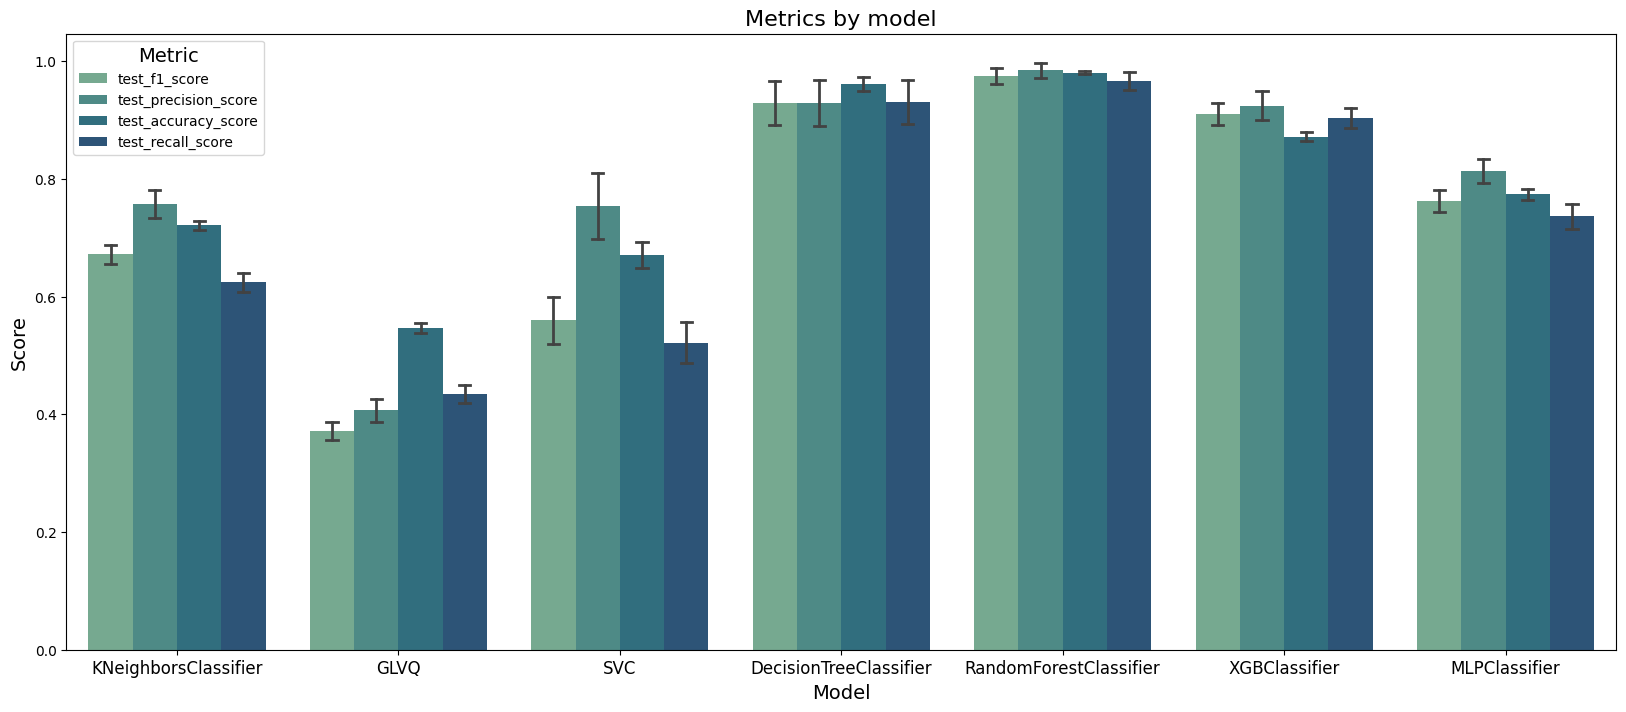

In [ ]:
# Plot metrics average with confidence intervals

import matplotlib.pyplot as plt
import seaborn as sns

results_long = stratified_crossval_results.melt(
    id_vars=["split", "model"],
    value_vars=[
        "test_f1_score",
        "test_precision_score",
        "test_accuracy_score",
        "test_recall_score",
    ],
    var_name="metric",
    value_name="score",
)

plt.figure(figsize=(20, 8))
sns.barplot(
    data=results_long, x="model", y="score", hue="metric", errorbar="sd", errwidth=2, capsize=0.05, palette="crest")
plt.title("Metrics by model", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(fontsize=12)
plt.legend(title="Metric", title_fontsize="14", loc="upper left")
plt.show()

### Friedman and Nemeyni Tests

In [ ]:
import numpy as np
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman


def perform_friedman_nemenyi_tests(df):
    metrics = [
        "test_f1_score",
        "test_precision_score",
        "test_accuracy_score",
        "test_recall_score",
    ]
    models = df["model"].unique()
    folds = df["split"].unique()

    results = {}
    for metric in metrics:
        results[metric] = np.zeros((len(models), len(folds)))
        for i, model in enumerate(models):
            for j, fold in enumerate(folds):
                results[metric][i, j] = df.loc[
                    (df["model"] == model) & (df["split"] == fold)
                ][metric].values[0]

    # Friedman test
    for metric in metrics:
        stat, p_value = friedmanchisquare(*results[metric])
        print(f"{metric}: Friedman Chi Square = {stat:.3f}, p-value = {p_value:.3f}")
        if p_value < 0.05:
            print("Significant difference between models\n")
        else:
            print("No significant difference between models")

    # Nemenyi test
    for metric in metrics:
        posthoc = posthoc_nemenyi_friedman(results[metric].T)
        print(f"\nNemenyi PostHoc Test for {metric}:")
        print(posthoc)


perform_friedman_nemenyi_tests(stratified_crossval_results)

ModuleNotFoundError: No module named 'scikit_posthocs'

### Box-Plot Analysis

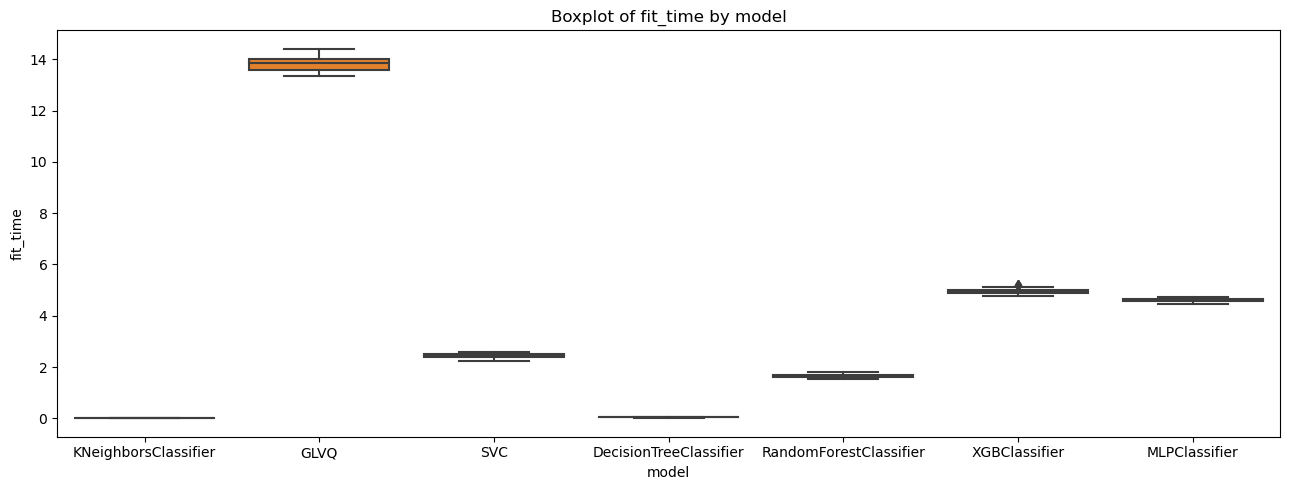

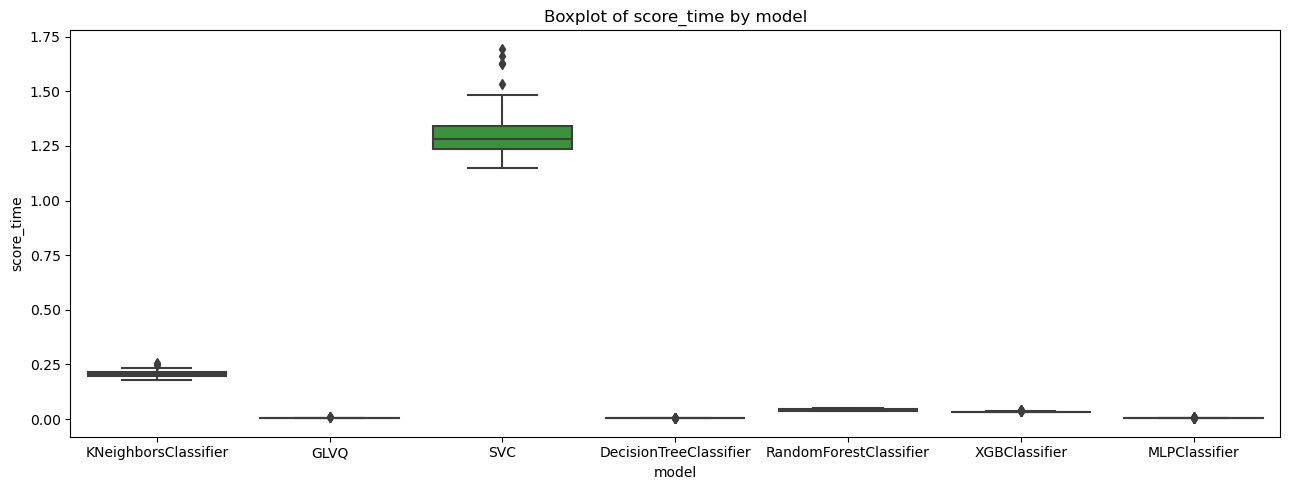

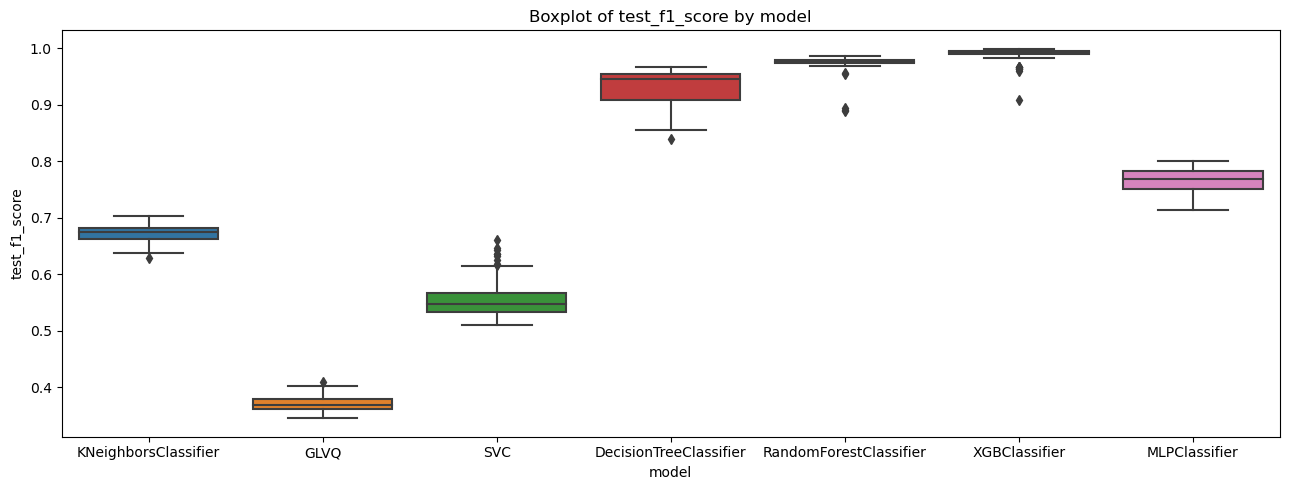

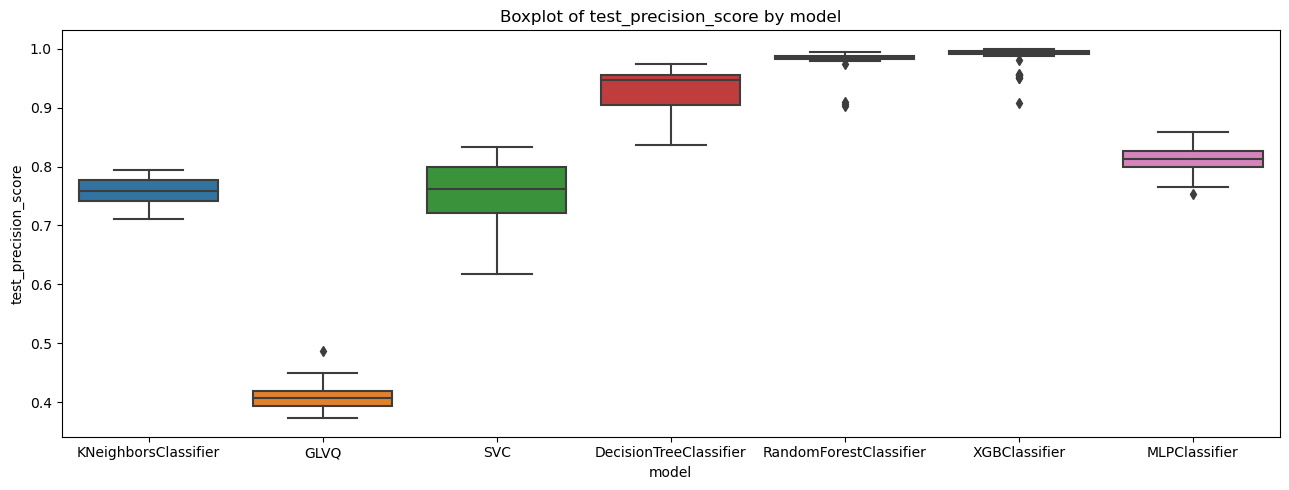

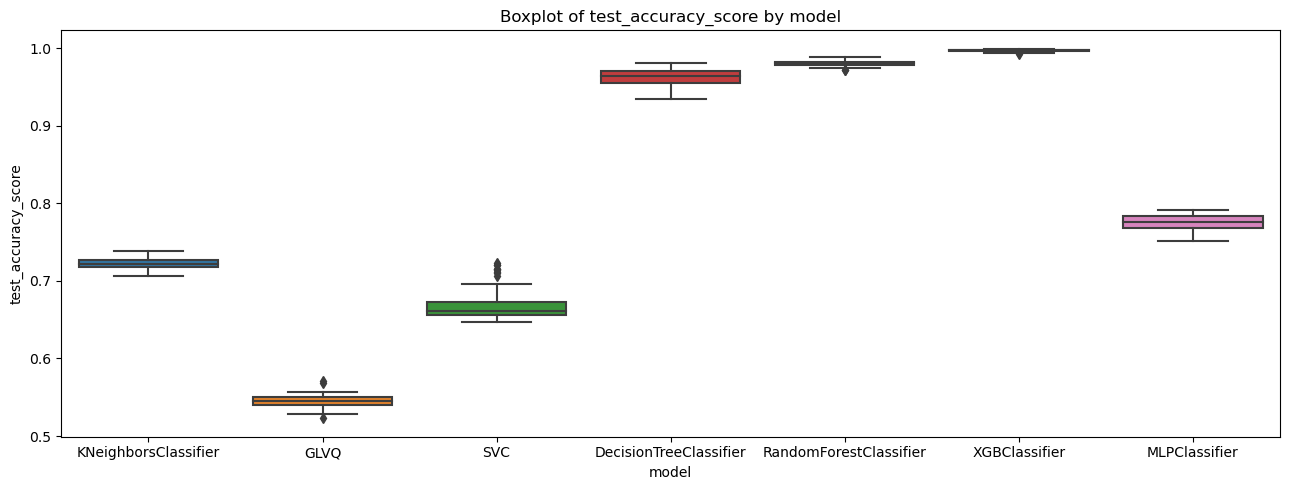

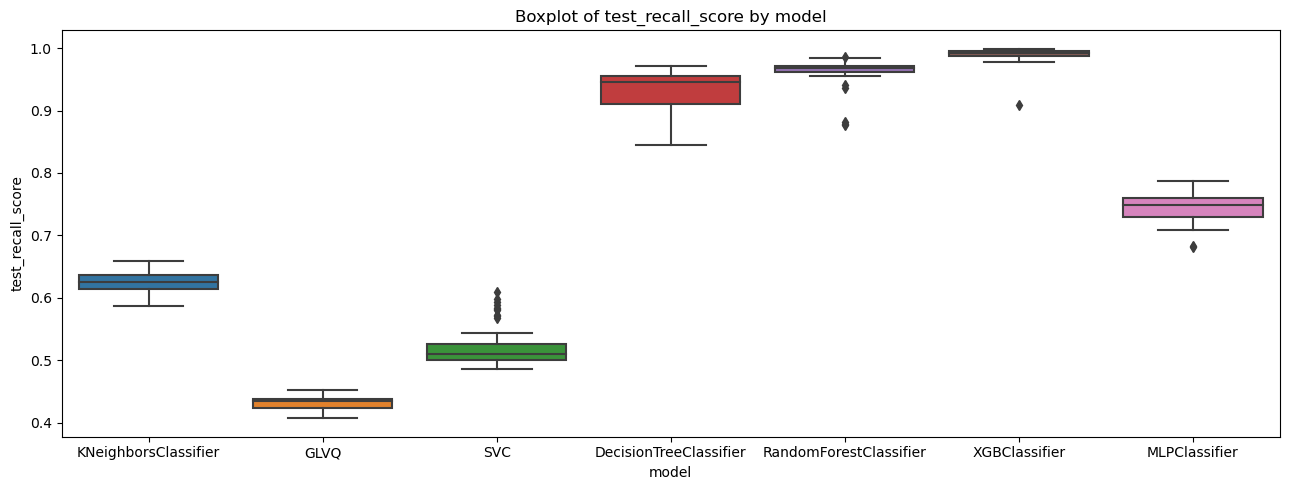

In [ ]:
# Analyse models with boxplots

# metrics to be analyzed
metrics = ['fit_time', 'score_time', 'test_f1_score', 'test_precision_score', 'test_accuracy_score', 'test_recall_score']

# create a separate plot for each metric
for metric in metrics:
    plt.figure(figsize=(13, 5))
    sns.boxplot(x='model', y=metric, data=stratified_crossval_results)
    plt.title(f'Boxplot of {metric} by model')
    plt.xticks()  # rotate x-axis labels
    plt.tight_layout()
    plt.show()



### Confusion Matrix

In [ ]:
# Fit models for comparison (when hyperparameters are tunned, pass tunning params to the model)

models = [
    KNeighborsClassifier(),
    GLVQ(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    MLPClassifier(),
]

models_results = {get_model_name(model): {} for model in models}

for model in models:
    print("Training model: ", get_model_name(model))

    timer = Timer()
    model.fit(X_train, y_train)
    metrics = compute_metrics(y_test, model.predict(X_test))
    metrics["fit_time"] = timer()
    models_results[get_model_name(model)] = metrics

Training model:  KNeighborsClassifier
Training model:  GLVQ
Training model:  SVC
Training model:  DecisionTreeClassifier
Training model:  RandomForestClassifier
Training model:  XGBClassifier
Training model:  MLPClassifier


c:\Users\willi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


c:\Users\Matheus\Documents\Git\machine_learning_ufpe_2023_2\venv\lib\site-packages\sklearn\ensemble\_forest.py:879: RuntimeWarning: invalid value encountered in divide
  proba /= len(self.estimators_)


AttributeError: 'list' object has no attribute 'take'

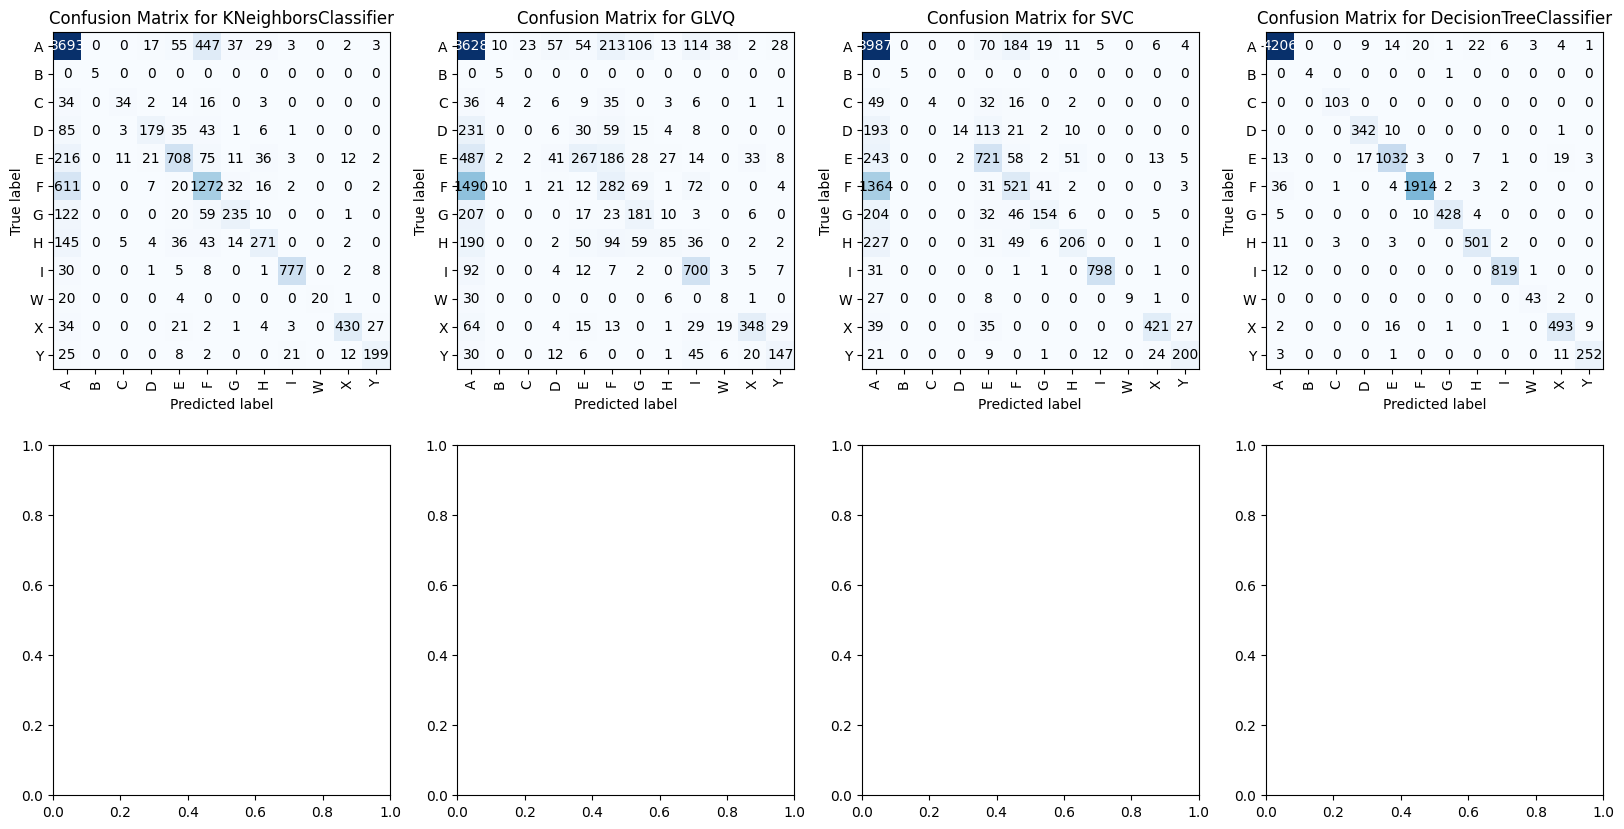

In [ ]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test, normalize=None, ax=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize=normalize)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    ax.imshow(cm, cmap=plt.cm.Blues)
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if normalize == 'true':
                text = f'{cm[i, j]:.2f}'
            else:
                text = str(cm[i, j])
            ax.text(j, i, text, ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")
    
    # fig.delaxes(axs[-1, -1])

    ax.set_xticks(range(len(label_encoder.classes_)))
    ax.set_xticklabels(label_encoder.classes_, rotation=90)
    ax.set_yticks(range(len(label_encoder.classes_)))
    ax.set_yticklabels(label_encoder.classes_)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"Confusion Matrix for {get_model_name(model)}")
    return ax


fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, model in enumerate(models):
    plot_confusion_matrix(model, X_test, y_test, ax=axes[i // 4, i % 4])
plt.tight_layout()
